In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import f1_score

sys.path.insert(0, '../python/')
from helpers import *

plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 14})
warnings.filterwarnings('ignore')

In [2]:
# features
# - hotel: [Resort Hotel, City Hotel] => [0, 1]
# - total_nights: [1, 2, 3, 4, 5, 6, 7, 8] => dummies
# - total_special_requests: [0, 1, 2] => dummies
# - market_segment: [Corporate, Online TA, Offline TA/TO, Direct, Groups] => dummies
# - room_difference: [0, 1]
# - party_size: [1, 2, 3] => dummies
# - booking_changes: [0, 1]


In [3]:
data = pd.read_csv('../../data/train/cancellations.csv')

# Clean and Prepare Data for Tuning

In [4]:
feats = ['hotel','market_segment', 'total_of_special_requests', 
         'total_nights', 'room_difference', 'party_size', 'booking_changes']
dummy_cols = ['total_nights', 'total_of_special_requests', 'market_segment', 'party_size']

X = data[feats].copy()

X.replace(['Resort Hotel', 'City Hotel'], [0, 1], inplace=True)
X.loc[np.argwhere((X['total_nights'] >= 8).values).flatten(), 'total_nights'] = 8
X.loc[np.argwhere((X['total_of_special_requests'] >= 2).values).flatten(), 'total_of_special_requests'] = 2
X.loc[np.argwhere(X['market_segment'].isin(['Aviation', 'Complementary']).values).flatten(), 'market_segment'] = 'Corporate'
X.loc[np.argwhere((X['party_size'] >= 3).values).flatten(), 'party_size'] = 3
X.loc[np.argwhere((X['booking_changes'] >= 1).values).flatten(), 'booking_changes'] = 1

X = pd.get_dummies(X, columns=dummy_cols).to_numpy()
y = data[['is_canceled']].to_numpy()

# Random Forest Gridsearch

In [5]:
pipe = Pipeline(steps=[('estimator', RandomForestClassifier())])


params = {'estimator__max_depth': [10],
          'estimator__max_features': ['sqrt', 'log2'],
          'estimator__n_estimators': [75],
          'estimator__criterion': ['gini', 'entropy'],
          'estimator__min_samples_leaf': [1, 2],
          'estimator__random_state': [1]}

grid = GridSearchCV(pipe, 
                    params, 
                    n_jobs=-1,
                    verbose=True,
                    scoring='f1')
grid.fit(X, y)

print("best parameters:", grid.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   30.5s finished


best parameters: {'estimator__criterion': 'entropy', 'estimator__max_depth': 10, 'estimator__max_features': 'sqrt', 'estimator__min_samples_leaf': 1, 'estimator__n_estimators': 75, 'estimator__random_state': 1}


Text(0, 0.5, 'F1 Score')

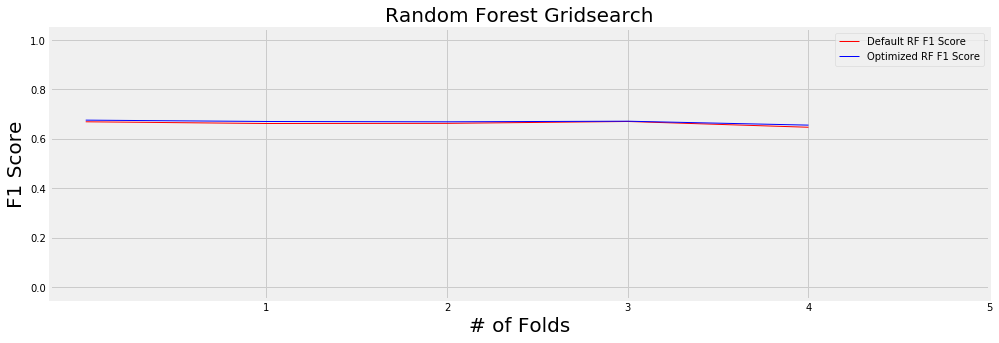

In [6]:
best_rf_model = grid.best_estimator_
default_rf = RandomForestClassifier()

models = [default_rf, best_rf_model]


fig, ax = plt.subplots(figsize=(15, 5))
plot_cross_val(models, X, y, ax, names=['Default RF', 'Optimized RF'], sampling_method=None )
ax.set_title('Random Forest Gridsearch', fontsize=20)
ax.legend()
ax.set_ylim(-0.05, 1.05)
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xlabel('# of Folds', fontsize=20)
ax.set_ylabel('F1 Score', fontsize=20)

In [14]:
pipe = Pipeline(steps=[('estimator', GradientBoostingClassifier())])


params = {'estimator__max_depth': [3],
          'estimator__max_features': ['sqrt', 'log2'],
          'estimator__n_estimators': [200],
          'estimator__loss': ['deviance', 'exponential'],
          'estimator__min_samples_leaf': [1, 2],
          'estimator__random_state': [1]}

grid = GridSearchCV(pipe, 
                    params, 
                    n_jobs=-1,
                    verbose=True,
                    scoring='f1')
grid.fit(X, y)

print("best parameters:", grid.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   54.8s finished


best parameters: {'estimator__loss': 'deviance', 'estimator__max_depth': 3, 'estimator__max_features': 'sqrt', 'estimator__min_samples_leaf': 1, 'estimator__n_estimators': 200, 'estimator__random_state': 1}


Text(0, 0.5, 'F1 Score')

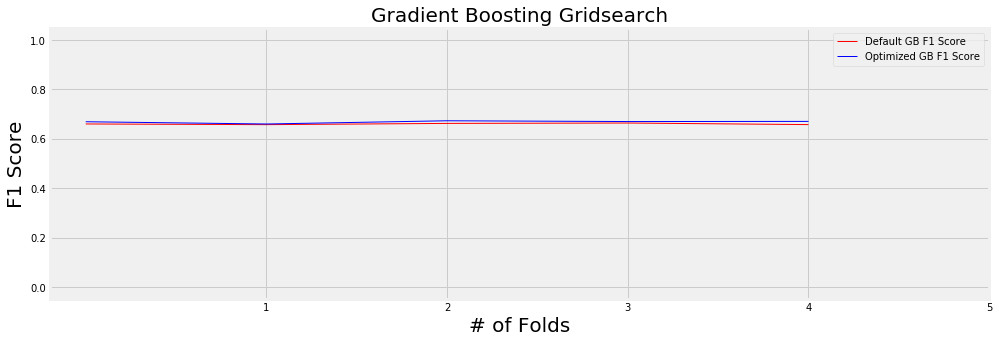

In [15]:
best_gb_model = grid.best_estimator_
default_gb = GradientBoostingClassifier()

models = [default_gb, best_gb_model]


fig, ax = plt.subplots(figsize=(15, 5))
plot_cross_val(models, X, y, ax, names=['Default GB', 'Optimized GB'], sampling_method=None )
ax.set_title('Gradient Boosting Gridsearch', fontsize=20)
ax.legend()
ax.set_ylim(-0.05, 1.05)
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xlabel('# of Folds', fontsize=20)
ax.set_ylabel('F1 Score', fontsize=20)

# Neural Net Approach

In [33]:
import tensorflow as tf
keras = tf.keras

def recall_m(y_true, y_pred):
    true_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + keras.backend.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + keras.backend.epsilon())
    return precision

def f1_m(y_true, y_pred):
    
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+keras.backend.epsilon()))

In [34]:
X.shape

(94470, 22)

In [157]:
# define the keras model
model = keras.models.Sequential()
model.add(keras.layers.Dense(20, input_dim=X.shape[1], activation='relu'))
model.add(keras.layers.Dense(20, activation='relu'))
# model.add(keras.layers.Dense(20, activation='relu'))
model.add(keras.layers.Dense(10, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [160]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_80 (Dense)             (None, 20)                460       
_________________________________________________________________
dense_81 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_82 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_83 (Dense)             (None, 1)                 11        
Total params: 1,101
Trainable params: 1,101
Non-trainable params: 0
_________________________________________________________________


In [163]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', f1_m])

In [164]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

n_epochs = 150
hist = model.fit(X_train, y_train, 
                 validation_data=(X_test, y_test),
                 epochs=n_epochs, 
                 batch_size=32, 
                 callbacks=[keras.callbacks.History()], 
                 verbose=1)

Epoch 1/150
2362/2362 [==============================] - 3s 1ms/step - loss: 0.5008 - acc: 0.7633 - f1_m: 0.6509 - val_loss: 0.5047 - val_acc: 0.7585 - val_f1_m: 0.6500
Epoch 2/150
2362/2362 [==============================] - 2s 1ms/step - loss: 0.5000 - acc: 0.7636 - f1_m: 0.6523 - val_loss: 0.5056 - val_acc: 0.7586 - val_f1_m: 0.6512
Epoch 3/150
2362/2362 [==============================] - 2s 1ms/step - loss: 0.4997 - acc: 0.7634 - f1_m: 0.6520 - val_loss: 0.5073 - val_acc: 0.7588 - val_f1_m: 0.6516
Epoch 4/150
2362/2362 [==============================] - 2s 1ms/step - loss: 0.4990 - acc: 0.7634 - f1_m: 0.6505 - val_loss: 0.5043 - val_acc: 0.7572 - val_f1_m: 0.6616
Epoch 5/150
2362/2362 [==============================] - 2s 1ms/step - loss: 0.4992 - acc: 0.7633 - f1_m: 0.6525 - val_loss: 0.5033 - val_acc: 0.7595 - val_f1_m: 0.6518
Epoch 6/150
2362/2362 [==============================] - 2s 1ms/step - loss: 0.4985 - acc: 0.7635 - f1_m: 0.6532 - val_loss: 0.5048 - val_acc: 0.7582 - val

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(3, figsize=(12, 24))

ax[0].plot(np.arange(n_epochs), hist.history['loss'], label='Training Loss')
ax[0].plot(np.arange(n_epochs), hist.history['val_loss'], label='Validation Loss')
ax[0].legend()
ax[0].set_title('Loss', fontsize=20)
ax[0].set_xlabel('Epochs', fontsize=20)

ax[1].plot(np.arange(n_epochs), hist.history['acc'], label='Training Accuracy')
ax[1].plot(np.arange(n_epochs), hist.history['val_acc'], label='Validation Accuracy')
ax[1].legend()
ax[1].set_title('Accuracy', fontsize=20)
ax[1].set_xlabel('Epochs', fontsize=20)
ax[1].set_ylim(0, 1)

ax[2].plot(np.arange(n_epochs), hist.history['f1_m'], label='Training F1')
ax[2].plot(np.arange(n_epochs), hist.history['val_f1_m'], label='Validation F1')
ax[2].legend()
ax[2].set_title('F1 Score', fontsize=20)
ax[2].set_xlabel('Epochs', fontsize=20)
ax[2].set_ylim(0, 1)

In [143]:
y_preds = model.predict(X_test)
y_preds = (y_preds > 0.5) * 1
f1_score(y_test, y_preds)

0.6629016255819278

In [144]:
np.unique(y_preds, return_counts=True)

(array([0, 1]), array([12767,  6127]))

Text(0, 0.5, 'Precision/Recall')

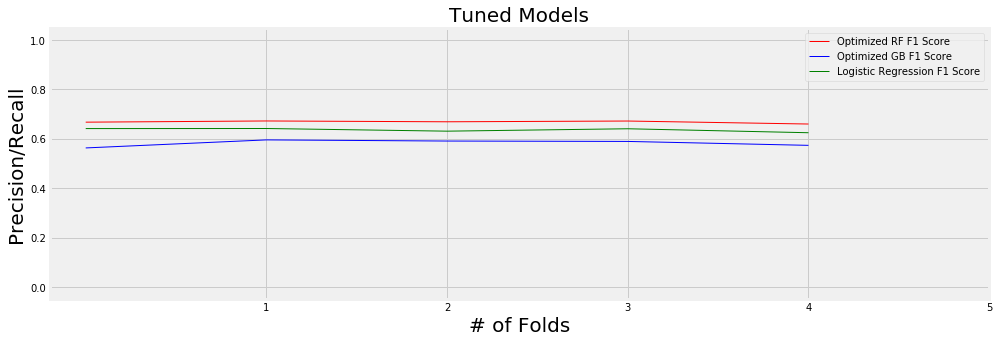

In [16]:
best_rf_model = RandomForestClassifier(criterion='entropy', max_depth=10, 
                                       max_features='sqrt', n_estimators=75)

best_gb_model = GradientBoostingClassifier(loss='deviance', 
                                           max_depth=3, 
                                           max_features='sqrt', 
                                           n_estimators=200,
                                           learning_rate=0.01)

models = [best_rf_model, best_gb_model, LogisticRegression()]


fig, ax = plt.subplots(figsize=(15, 5))
plot_cross_val(models, X, y, ax, names=['Optimized RF', 'Optimized GB', 'Logistic Regression'], sampling_method=None )
ax.set_title('Tuned Models', fontsize=20)
ax.legend()
ax.set_ylim(-0.05, 1.05)
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xlabel('# of Folds', fontsize=20)
ax.set_ylabel('Precision/Recall', fontsize=20)